# Hands-on 01: Online retail - Cohort Analysis

## Concepts


One key go-to idea to uncover customer behavior is to spliting them into smaller groups that within each group they are more similar to each other.
That make the insights is cleared, comparing to doing analysis on the whole population. 

You will notice that they have done it by multiple ways in our analytics works: splitting customers by geo, app, level of values, etc.
In this hands-on, we try 3 techniques, serving that purpose: 

1. Cohort 
2. RFM segmentation 
3. KMeans clustering

We start with **Cohort analysis**, we commonly segment customers by the date they onboard with the app/products, 
with the assumption that each snapshot of time, we acquire a group of customers (as a cohort). 
The product offerings and marketing strategies are the same, so we expect customers in the same cohort are more or less comparable. 

In fact, cohorts is not necessarily defined as the time of acquiring customers, but other given factors that make the group of customers more similar.
The cohort by the starting time of customers give a view of how the product evolve over time, and how the customer base shift over time.


### What's cohort?
- *A cohort*: Individuals have some common in characteristics 
	- For example, users acquired through a same marketing campaign at the same date
	- First batch of students of an online course
- Cohort analysis is a useful way to compare groups of entities over time
	- Provide a framework to **detect correlations between cohort characteristics and long-term trends** -> Hypotheses about the causal drivers.
	- Compare new cohorts of customers and compare to previous cohorts -> Alerts when something has gone wrong


### Components of Cohort Analysis

Cohort analyses have three components

1. `Cohort grouping`: often based on the start date (customer's first purchase, subscription date, the date a student started school, etc.)
2. Time series of data over which a cohort is observed: 
    - A series of purchases, logins, interactions, Active Time Spent day-by-day after the start date
    - A series should cover the the entire life span (mature) 
    - A series should be long enough to complete the action of interest -> For example, if customers tend to purchase once a month, a time series of several months is needed. If, on the other hand, purchases happen only once a year, a time series of several years would be preferable.
    - Period is relative to the start date (for example, day0, day1, day2, etc.)
3. Aggregate metrics that we want to measures: Retention, Revenue along the life-cycle. Any metrics that matters to the health of the business -> Aggregate `sum`, `count`, `average`

Go through the notebook and fill in TODO part (Google might help you along the way). 
**There are 09 in total**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import pandas as pd 
import missingno

In [2]:
# OPTIONA:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [5]:
!ls ../data/01_raw/online_retail.xlsx

online_retail.xlsx     online_retail.xlsx.dvc


In [6]:
# TODO_01
df = pd.read_excel('../data/01_raw/online_retail.xlsx', dtype={'CustomerID': str})

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [8]:
# TODO_02: Create order_value = Quantity x UnitPrice
df['order_value'] = df.Quantity * df.UnitPrice

## Data Explore

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
 8   order_value  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
order_value,541909.0,17.987795,378.810824,-168469.60,3.40,9.75,17.40,168469.6


In [11]:
# TODO_03: Using missingno to explore the missing values of datasets
df.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
order_value    0.000000
dtype: float64

In [19]:
# Filter NULL
df2 = df[~df.CustomerID.isnull()].copy()
df2.isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
order_value    0.0
dtype: float64

## Cleaning Data

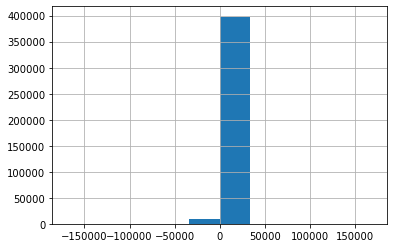

In [21]:
df2.order_value.hist();

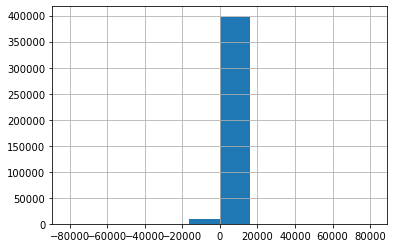

In [23]:
df2.Quantity.hist();

In [26]:
df2.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,1.00,2.00,5.00,12.00,36.0,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,0.42,1.25,1.95,3.75,8.5,38970.0
order_value,406829.0,20.401854,427.591718,-168469.6,0.85,4.20,11.10,19.50,67.2,168469.6


In [27]:
# TODO_04: Look at histogram by .hist() above => Determine the outliers to filter the data
quantity_cap = 40
order_value_cap = 60 
order_value_flr = 0

df2 = df[(df.Quantity <= quantity_cap) & (df.order_value <= order_value_cap) & (df.order_value > order_value_flr)]
df2.dropna(inplace=True)
df2.describe()

,Quantity,UnitPrice,order_value
count,368995.000000,368995.000000,368995.000000
mean,7.201241,2.853053,12.634446
std,7.202644,3.094990,10.509715
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.200000
50%,4.000000,1.950000,10.200000
75%,12.000000,3.750000,17.400000
max,40.000000,59.950000,60.000000


## Prepare the Data for Cohort Analysis

### Step 1. `invoice_period`

Generate the invoice_period by extracting Year-Month of InvoiceDate. By this, we change the frequency from Daily to Monthly.

In [28]:
df2['invoice_period'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_value,invoice_period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


### Step 2. `cohort_group`

- Set index to `CustomerID`
- `groupby(level=0)` which is equivalent to groupby `CustomerID`
- Remember the reset the index

> Discussion: What happend if we do not set the index and `groupby(level=0)`? Hint: Try to run `groupby('CustomerID')` directly?

In [29]:
# groupby will return the series with length shorter the the original, by the trick of set index, it enables us to group by, keep the original length
df2.set_index('CustomerID', inplace=True) 
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_value,invoice_period
CustomerID,,,,,,,,,
17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12
17850,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12
17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12
17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12
17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12


In [30]:
# TODO_05: From the code below, how the cohort_group is defined?
df2['cohort_group'] = df2.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df2.head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_value,invoice_period,cohort_group
CustomerID,,,,,,,,,,
17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12,2010-12
17850,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12,2010-12
17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12


In [31]:
df2.reset_index(inplace=True)
df2.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_value,invoice_period,cohort_group
0,17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,15.30,2010-12,2010-12
1,17850,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
2,17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,22.00,2010-12,2010-12
3,17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12
4,17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,20.34,2010-12,2010-12


### Step 3. Aggregate Metrics

In [32]:
# TODO_06: 
# Later, we want to visualize the activities of customers (in terms of quantity & value) 
# month-over-month and split by cohorts
# WHAT we should pass on groupby?

g = df2.groupby(['cohort_group', 'invoice_period'])
cohorts = g.agg({
    'CustomerID': pd.Series.nunique,
    'Description': pd.Series.nunique,
    'Quantity': np.sum,
    'order_value': np.sum
})
cohorts.rename(columns={
    'CustomerID':'cust_cnt',
    'Description':'product_item_cnt',
    'Quantity':'total_quant',
    'order_value':'total_value'
}, inplace=True)
cohorts.head()

cust_cnt  product_item_cnt  total_quant  \
cohort_group invoice_period                                            
2010-12      2010-12              831              2381       159373   
             2011-01              301              1732        70605   
             2011-02              256              1638        54236   
             2011-03              307              1792        70382   
             2011-04              293              1738        63735   

                             total_value  
cohort_group invoice_period               
2010-12      2010-12           305028.90  
             2011-01           123563.70  
             2011-02            98170.64  
             2011-03           123349.99  
             2011-04           108308.37

### Step 4. `cohort_period`

We want to count the transaction month relative from cohort_date (ie. 1, 2, 3 month after the date of acquired - cohort_date)

In [33]:
def cohort_period(df):
  df['cohort_period'] = np.arange(len(df)) + 1
  return df

In [34]:
cohorts = cohorts.groupby(level=0).apply(cohort_period) # level 0: cohort_group, apply for each row (invoice_periods)
cohorts.head()

cust_cnt  product_item_cnt  total_quant  \
cohort_group invoice_period                                            
2010-12      2010-12              831              2381       159373   
             2011-01              301              1732        70605   
             2011-02              256              1638        54236   
             2011-03              307              1792        70382   
             2011-04              293              1738        63735   

                             total_value  cohort_period  
cohort_group invoice_period                              
2010-12      2010-12           305028.90              1  
             2011-01           123563.70              2  
             2011-02            98170.64              3  
             2011-03           123349.99              4  
             2011-04           108308.37              5

In [35]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_period','cohort_group'], inplace=True)
cohorts.head()

,,invoice_period,cust_cnt,product_item_cnt,total_quant,total_value
cohort_period,cohort_group,,,,,
1,2010-12,2010-12,831,2381,159373,305028.90
2,2010-12,2011-01,301,1732,70605,123563.70
3,2010-12,2011-02,256,1638,54236,98170.64
4,2010-12,2011-03,307,1792,70382,123349.99
5,2010-12,2011-04,293,1738,63735,108308.37


## Cohort Analysis

### Monthly Total Sales Across Cohorts

In [36]:
cohorts['total_value'].unstack(0)

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_group,,,,,,,,,,,,,
2010-12,305028.900,123563.70,98170.64,123349.99,108308.37,138580.14,123899.84,122222.51,124412.190,163777.65,153480.18,232685.93,80661.68
2011-01,130471.320,25481.27,32278.66,24790.71,46510.35,39501.25,34303.07,33499.56,46945.231,58849.81,67975.46,13917.80,NaN
2011-02,118424.080,16413.03,22487.75,36162.62,31384.81,24378.90,32098.95,43234.68,38406.460,41351.27,7384.01,NaN,NaN
2011-03,146188.530,19883.36,36604.13,31787.27,31376.05,30084.23,43680.32,46489.70,49740.160,9805.78,NaN,NaN,NaN
2011-04,93908.211,19032.03,17131.99,18106.62,17608.70,24729.54,23978.01,26969.51,5676.780,NaN,NaN,NaN,NaN
2011-05,83261.320,12760.18,13520.29,14575.10,23122.73,26787.71,26651.23,8818.23,NaN,NaN,NaN,NaN,NaN
2011-06,67798.600,8602.29,10552.17,19456.34,19970.29,27915.47,5877.51,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,59027.221,7996.44,14171.47,16440.78,16952.27,5691.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,63252.100,15653.36,29636.04,31901.03,11977.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


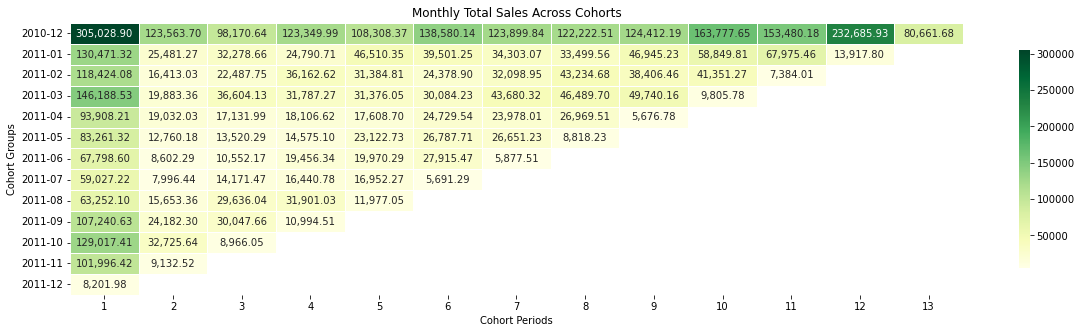

In [38]:
unstacked_value = cohorts['total_value'].unstack(0)
plt.figure(figsize=(20,5))
ax = sns.heatmap(unstacked_value, annot=True, cmap='YlGn',fmt=",.2f", 
           linewidths=1,
           cbar_kws={"shrink": .8})
ax.set_ylabel('Cohort Groups')
ax.set_xlabel('Cohort Periods')
ax.set_title('Monthly Total Sales Across Cohorts');

In [ ]:
# TODO_07: Comments and highlight any insights from the charts

### Retention

> Retention of each cohort over time (periods) is the number of active users at each period, divide for the cohort size (= user count in first periods)
- Size of cohort (`denomiator`)
- Spread the `cust_cnt` - active users over periods of each cohorts
- Divide for the **retention rate**: `cust_retention.divide(cohorts_size, axis=0)`

In [39]:
# TODO_08: With the piece of code below, how the cohorts size is defined?
cohorts_size = cohorts.groupby(level=1)['cust_cnt'].first()
cohorts_size

cohort_group
2010-12    831
2011-01    397
2011-02    361
2011-03    439
2011-04    295
2011-05    280
2011-06    239
2011-07    195
2011-08    165
2011-09    293
2011-10    356
2011-11    316
2011-12     38
Name: cust_cnt, dtype: int64

In [40]:
cust_retention = cohorts['cust_cnt'].unstack(0)
cust_retention.head()

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_group,,,,,,,,,,,,,
2010-12,831.0,301.0,256.0,307.0,293.0,327.0,300.0,275.0,284.0,315.0,300.0,412.0,211.0
2011-01,397.0,84.0,107.0,87.0,129.0,115.0,98.0,98.0,123.0,131.0,148.0,48.0,NaN
2011-02,361.0,61.0,66.0,98.0,96.0,89.0,88.0,95.0,92.0,109.0,24.0,NaN,NaN
2011-03,439.0,66.0,108.0,88.0,98.0,78.0,111.0,102.0,120.0,39.0,NaN,NaN,NaN
2011-04,295.0,59.0,57.0,59.0,56.0,67.0,65.0,74.0,21.0,NaN,NaN,NaN,NaN


In [41]:
cust_retention = cust_retention.divide(cohorts_size, axis=0)
cust_retention 

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_group,,,,,,,,,,,,,
2010-12,1.0,0.362214,0.308063,0.369434,0.352587,0.393502,0.361011,0.330927,0.341757,0.379061,0.361011,0.495788,0.253911
2011-01,1.0,0.211587,0.269521,0.219144,0.324937,0.289673,0.246851,0.246851,0.309824,0.329975,0.372796,0.120907,NaN
2011-02,1.0,0.168975,0.182825,0.271468,0.265928,0.246537,0.243767,0.263158,0.254848,0.301939,0.066482,NaN,NaN
2011-03,1.0,0.150342,0.246014,0.200456,0.223235,0.177677,0.252847,0.232346,0.273349,0.088838,NaN,NaN,NaN
2011-04,1.0,0.200000,0.193220,0.200000,0.189831,0.227119,0.220339,0.250847,0.071186,NaN,NaN,NaN,NaN
2011-05,1.0,0.185714,0.178571,0.164286,0.217857,0.221429,0.267857,0.092857,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.179916,0.154812,0.263598,0.225941,0.326360,0.100418,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.158974,0.220513,0.235897,0.282051,0.128205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.193939,0.254545,0.248485,0.139394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


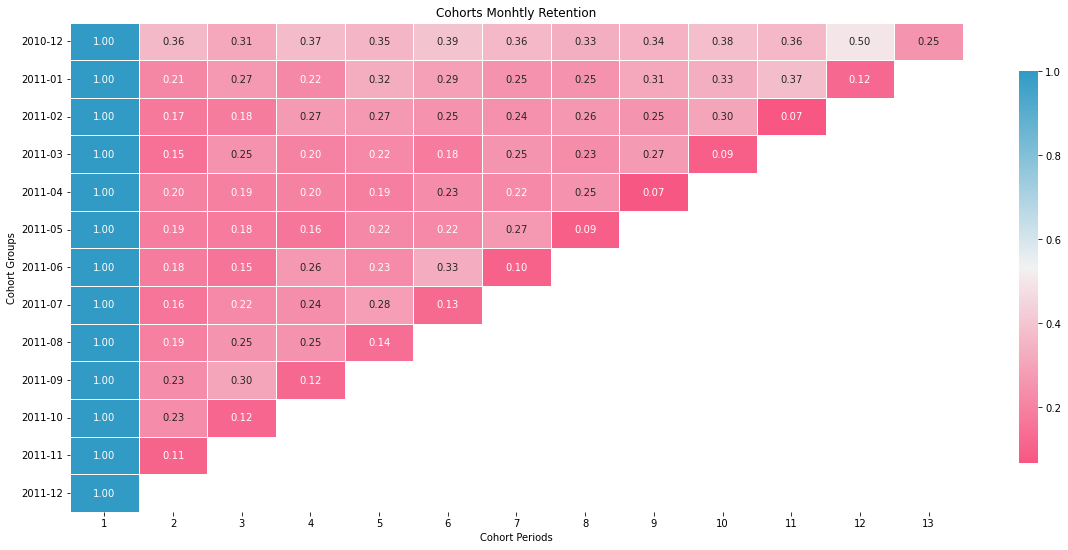

In [43]:
plt.figure(figsize=(20,9))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
ax = sns.heatmap(cust_retention, annot=True, cmap=cmap,fmt=".2f", 
           linewidths=1,
           cbar_kws={"shrink": .8})
ax.set_ylabel('Cohort Groups')
ax.set_xlabel('Cohort Periods')
ax.set_title('Cohorts Monhtly Retention');

In [ ]:
# TODO_09: Comments and highlight any insights from the charts